## Red Neuronal MultiCapa, OOP model

In [118]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Importar Images

In [119]:
from get_images import get_images

In [120]:
# MNIST path
mnist_path = './mnist_raw/'
x_train_num, y_train_num, x_test_num, y_test_num = get_images(mnist_path)

# Extraemos los primeros 5k datos, y los reagrupamos en 5k filas,y comlumnas como el producto flotante de 28*28 (por eso el -1)
x_train = x_train_num[:50000].reshape(50000, -1).astype(float)
y_train = y_train_num[:50000].reshape(50000, 1) # Extraemos 5k datos y los formatemaos en 5k filas y una sola columna.
# Validation Set
x_val = x_train_num[50000:].reshape(10000, -1).astype(float)
y_val = y_train_num[50000:].reshape(10000, 1)
# Set de pruebas
x_test = x_test_num.copy().reshape(10000, -1).astype(float)
y_test = y_test_num.copy().reshape(10000, 1)


### Hasta este punto tenemos 3 sets
- Un set de Entrenamiento   $\to$ Es el set mas grande y son los datos para entrenar el modelo
- Un set de validación      $\to$ Es para afinar el modelo y ver que tan bien esta funcionando
- Un Set de Pruebas         $\to$ Sera la prueba final del modelo.

In [121]:
x_train.mean(), x_train.std(), x_train.min()

(33.39512885204082, 78.6661972212754, 0.0)

### Para normalizar los datos
### $\frac{X_{\text{data}}-X_{\text{mean}}}{X_{\text{std}}}$

In [122]:
def normalise(x_mean, x_std, x_data): # Función para normalizar los datos
    return (x_data - x_mean) / x_std

In [123]:
x_mean = x_train.mean() # sacamos la media
x_std = x_train.std()   # sacamos el std

# Normalizamos nuestros Set's de datos
x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [124]:
x_train.mean(), x_train.std() # Nos quedamos con una media muy pequeña y un STD sercano a 1

(-9.646705203355238e-18, 0.9999999999999997)

### Graficar muestras

In [125]:
def plot_number(image): # Grafica un numero 
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: 2


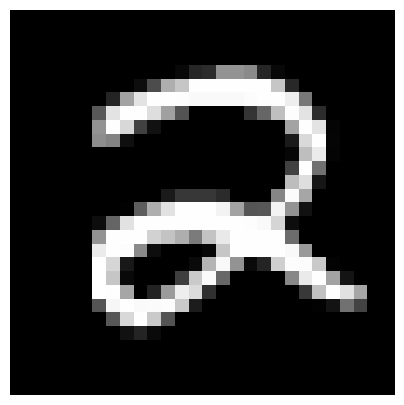

In [126]:
# Grafica un numero random
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx, 0]}')
plot_number(x_test_num[rnd_idx])

Podemos observar como nos da una imagen aleatoria y el resultado correcto de esta imagen

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [127]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    x  #muestras, 784
    y #muestras, 1
    '''
    print(x.shape[0], y.shape[0])
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras' # Aseguramos que la cantidad de muestras sea la misma
    total_data = x.shape[0] # Obtenemos la cantidad de muestras
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Init parameters

In [128]:
# Esta jalada no sirve de nada, la sacamos de internet
def init_parameters(input_size,neurons):
    
    W1 = np.random.randn(neurons[0], input_size)*0.001
    b1 = np.zeros((neurons[0],1))
    
    W2 = np.random.randn(neurons[1],neurons[0]*0.001)
    b2 = np.zeros((neurons[1],1))
    
    return{'W1':W1,'b1':b1 ,'W2':W2,'b2':b2}

## Nuestra clase Linear, ReLU y Sequential

In [129]:
class np_tensor(np.ndarray):pass # Clase para definir un tensor, que es una matriz de numpy, pero con un nombre para poder identificarlo

In [130]:
a = np.array([0, 0])
b = a.view(np_tensor)

In [131]:
type(a)

numpy.ndarray

In [132]:
type(b)

__main__.np_tensor

In [133]:
a == b

np_tensor([ True,  True])

In [134]:
print(a is b) 


False


###  Clase Linear

In [135]:
class Linear(): # Clase para definir una capa lineal
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        self.W = (np.random.randn(output_size, input_size) /np.sqrt(input_size/2)).view(np_tensor) # Inicializamos los pesos de forma aleatoria
        self.b = np.zeros((output_size, 1)).view(np_tensor) # Inicializamos los bias en 0
        
    def __call__(self, X): # esta el foward de la clase lineal
        Z= self.W @ X + self.b # Multiplicamos los pesos por la entrada y le sumamos el bias
        return Z
        
    def backward(self, X, Z): # esta es la parte de backpropagation
        X.grad = self.W.T @ Z.grad # Calculamos el gradiente de la entrada
        self.W.grad = Z.grad @ X.T # Calculamos el gradiente de los pesos
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True) # Calculamos el gradiente del bias
        

### Clase ReLU

In [136]:
class ReLU(): # Clase para la función de activación ReLU, debe regresar el calor maximo entre 0 y el valor de Z
    def __call__(self, Z):
        return np.maximum(0, Z) # Regresamos el valor maximo entre 0 y Z
    
    def backward(self, Z, A):
        Z.grad = A.grad.copy() # Copiamos el gradiente de A a Z
        Z.grad[Z < 0] = 0 # Si Z es menor a 0, el gradiente es 0
        return Z.grad

### Clase Sequential

In [137]:
class Sequential_layers():
    def __init__(self, layers): # Inicializamos las capas
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}

    def __call__(self, X): # Forward de la red
        self.x = X
        self.outputs['l0'] = self.x #El diccionario tien como llave L0
        for i, layer in enumerate(self.layers,1):
          self.x=layer(self.x)
          self.outputs['l'+str(i)] = self.x
        return self.x # La salida de la ultima capa.

    def backward(self):
        for i in reversed(range(len(self.layers))):
          self.layers[i].backward(self.outputs['l' + str(i)], self.outputs['l' + str(i + 1)])

    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
          if isinstance(layer, ReLU): continue
          layer.W = layer.W - learning_rate * layer.W.grad
          layer.b = layer.b - learning_rate * layer.b.grad

    # Predicts the image
    def predict(self, X):
        return np.argmax(self(X))

### Cost Function

In [138]:
# Scores if the entry for softmax
def softmaxXEntropy(x, y):
  exp_scores = np.exp(x)
  sum_exp_scores = np.sum(exp_scores, axis = 0, keepdims = True)
  probs = exp_scores/sum_exp_scores

  # XEntropy
  y_hat = probs[y.squeeze(), np.arange(x.shape[1])]
  cost = np.mean(-np.log(y_hat))
  probs[y.squeeze(), np.arange(x.shape[1])] -= 1

  x.grad = probs
  return probs, cost
  
  

### Loop de entrenamiento

In [139]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3): # Función para entrenar el modelo
    for epoch in range(epochs): # Recorremos las épocas
        for i,(x,y) in enumerate(create_minibatches(mb_size, x_train, y_train)): # Recorremos los minibatches
            scores = model(x.T.view(np_tensor)) # Obtenemos los scores
            _,cost = softmaxXEntropy(scores, y) # Calculamos el costo
            model.backward() # Backpropagation
            model.update(learning_rate) # Actualizamos los pesos
            
        print(f'Epoch: {epoch} - Costo: {cost.mean()}') # Imprimimos el costo

In [146]:
def accuracy(model,x, y, mb_size): # Función para calcular la precisión del modelo
    correct = 0
    total = 0
    for i, (x,y) in enumerate (create_minibatches(mb_size, x, y)): # Recorremos los minibatches
        pred = model(x.T.view(np_tensor)) # Obtenemos las predicciones
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze()) # Sumamos las predicciones correctas
        total += pred.shape[1] # Sumamos el total de predicciones
    return correct/total

In [141]:
model = Sequential_layers([Linear(784, 200), ReLU(), Linear(200, 200), ReLU(), Linear(200, 10)])
mb_size = 512
learning_rate = 1e-4
epochs = 20


In [142]:
train(model, epochs, mb_size, learning_rate)

50000 50000


Epoch: 0 - Costo: 0.2923410646562736
50000 50000
Epoch: 1 - Costo: 0.16888781072819137
50000 50000
Epoch: 2 - Costo: 0.19945193693563332
50000 50000
Epoch: 3 - Costo: 0.19364229610812386
50000 50000
Epoch: 4 - Costo: 0.12306251468736244
50000 50000
Epoch: 5 - Costo: 0.22974341465270406
50000 50000
Epoch: 6 - Costo: 0.08459504735720388
50000 50000
Epoch: 7 - Costo: 0.155938757621985
50000 50000
Epoch: 8 - Costo: 0.17975278457694413
50000 50000
Epoch: 9 - Costo: 0.07653311731190317
50000 50000
Epoch: 10 - Costo: 0.10739236018213509
50000 50000
Epoch: 11 - Costo: 0.09348009381547806
50000 50000
Epoch: 12 - Costo: 0.0662559820101726
50000 50000
Epoch: 13 - Costo: 0.05713285095204463
50000 50000
Epoch: 14 - Costo: 0.12378015654792197
50000 50000
Epoch: 15 - Costo: 0.087610450052576
50000 50000
Epoch: 16 - Costo: 0.0543266628069236
50000 50000
Epoch: 17 - Costo: 0.04331822549220271
50000 50000
Epoch: 18 - Costo: 0.042793540962715995
50000 50000
Epoch: 19 - Costo: 0.05816395416698712


In [147]:
train(model, epochs, mb_size, learning_rate)

50000 50000
Epoch: 0 - Costo: 0.020138707746782506
50000 50000
Epoch: 1 - Costo: 0.01599543118234803
50000 50000
Epoch: 2 - Costo: 0.01860841702548958
50000 50000
Epoch: 3 - Costo: 0.022175645868682516
50000 50000
Epoch: 4 - Costo: 0.013815438142274166
50000 50000
Epoch: 5 - Costo: 0.020857966413346068
50000 50000
Epoch: 6 - Costo: 0.02164972407291364
50000 50000
Epoch: 7 - Costo: 0.016460416859528
50000 50000
Epoch: 8 - Costo: 0.012348597786039493
50000 50000
Epoch: 9 - Costo: 0.02008609085888698
50000 50000
Epoch: 10 - Costo: 0.012924882207942714
50000 50000
Epoch: 11 - Costo: 0.009963127673822082
50000 50000
Epoch: 12 - Costo: 0.009724836781899508
50000 50000
Epoch: 13 - Costo: 0.012997594637552583
50000 50000
Epoch: 14 - Costo: 0.014926506794317814
50000 50000
Epoch: 15 - Costo: 0.020453797652406555
50000 50000
Epoch: 16 - Costo: 0.00924046425973867
50000 50000
Epoch: 17 - Costo: 0.016657394976715062
50000 50000
Epoch: 18 - Costo: 0.008015147253224157
50000 50000
Epoch: 19 - Costo:

In [148]:
print(accuracy(model,x_test, y_test, mb_size))

10000 10000
0.9765


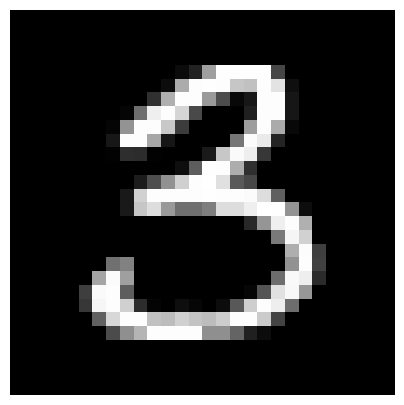

el valor predicho es: 3, el valor real es:3


In [149]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])
pred = model.predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}, el valor real es:{y_test[idx][0]}')

In [ ]:
a = [33, 44, 555, 666]

In [ ]:
for i in reversed(range(len(a))):
    print(a[i])